This file contains code to get the sound speed PCs for large basis sizes (>128*128)

In [2]:
# external imports
import numpy as np
from numpy import exp, log, log10, sqrt, zeros, ones, linspace
import matplotlib.pyplot as plt
import numba
import pickle

# other project files
import modes
import spectra
import util

In [3]:
# numerical parameters
NT = 2**13
NK = 2**11
NX = 10000
L_MAX = 2500
xmin = 0.01
xmax = 3000
a0 = 1.e-6
a0_pca = 5.e-5
a_rec = 1/1100

# arrays
A = np.linspace(a0, a_rec, 2*NT)
K = np.linspace(.1, 800, NK)
L = np.array([i for i in range(2, 50, 1)]+[i for i in range(50, 200, 5)] +
                  [i for i in range(200, L_MAX+1, 20)])
L_eval = np.arange(2, L_MAX+1)
NL = len(L)
X = np.linspace(xmin, xmax, NX)
JLX, DJLX = spectra.get_bessels(L, X)

Bessel functions loaded from file.


In [4]:
"""Helper functions for cs2 PCA"""

@numba.njit
def square_basis(theta, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    for i in range(NC**2):
        r,c = i//NC, i%NC
        out[r*width:(r+1)*width, c*height:(c+1)*height] = theta[i]
    out[:,A[::2] < a0_pca]=0
    return out.T

def get_square(n, val, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    r,c = n//NC, n%NC
    out[r*width:(r+1)*width, c*height:(c+1)*height] = val
    out[:,A[::2] < a0_pca]=0
    return out.T

In [5]:
# physical parameters
h = 0.6774
As = np.exp(3.064)/1.e10 # scalar perturbation amplitude
TCMB0 = 2.72548 * 1.e6 # CMB temp (microK)
OmegaM0 = 0.3089
OmegaB0 = 0.0486
OmegaR0 = 4.2e-5/h**2
OmegaN0 = OmegaR0*(1-1/1.68)
OmegaG0 = OmegaR0 - OmegaN0
OmegaC0 = OmegaM0 - OmegaB0
wC = np.zeros(2*NT)
wN = np.ones(2*NT)*1/3
cs2C = np.zeros((2*NT, NK))
cs2N = np.ones((2*NT, NK))*1/3
params_F = [wC, cs2C, wN, cs2N, OmegaB0, OmegaC0, OmegaG0, OmegaN0, As, TCMB0, h]

Cl = spectra.get_Cl_3fld(L, L_eval, X, JLX, DJLX, A, K, *params_F)
err = spectra.get_Cl_err(L_eval,Cl)
Sigma = np.diag(err**2)


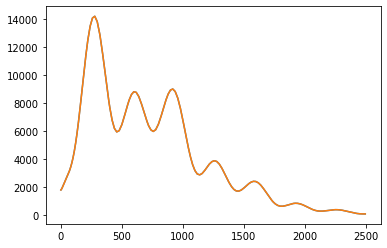

In [6]:
"""Get the fiduciary parameters for the 2-fluid model"""

# solve for perturbation history using 3-fluid model.
Y, TAU = modes.solve_3fld(A, K, wC, cs2C, wN, cs2N, OmegaB0, OmegaC0,
           OmegaG0, OmegaN0)

Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC =Y[:, 3, :].T
vC = Y[:, 4, :].T
deltaN = Y[:, 5, :].T
vN =Y[:, 6, :].T

OmegaB = OmegaB0 * A[::2]**-3
OmegaC = OmegaC0 * A[::2]**-3
OmegaN = OmegaN0 * A[::2]**-4
OmegaG = OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC

# calculate GDM functions
wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN/3)/(deltaD*OmegaD)
delta_pD = deltaN

deltaD, vD, cs2D, delta_pD = deltaD.T, vD.T, cs2D.T, delta_pD.T

Cl2 = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
plt.plot(Cl)
plt.plot(Cl2)

In [8]:
def CS2_DERIV(q, t, a0):
    """Take derivatives of Cl w.r.t. sound speed basis coefficients.
    """
    NC = 2**q # number of basis elements
    ss = 0.1**t # derivative step size
    
    # take the central-difference derivatives of Cl w.r.t. cs2 basis coefficients.
    J = np.zeros((len(L_eval), NC**2))
    print('computing derivatives (t='+str(t)+')')
    for n in range(NC**2):
        delta_cs2 = get_square(n, ss, NC)
        Cl_fwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D+delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        Cl_bwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D-delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
        if(n % 10 == 0):
            print(str(n) + ' of ' + str(NC**2))
    
    # save the derivatives
    pickle.dump(J, open("output/cs2-only/J_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (q='+str(q)+',t='+str(t)+')')

In [9]:
@numba.njit
def CS2_DERIV2(q, t, a0):
    """Take derivatives of Cl w.r.t. sound speed basis coefficients.
    """
    NC = 2**q # number of basis elements
    ss = 0.1**t # derivative step size
    
    # take the central-difference derivatives of Cl w.r.t. cs2 basis coefficients.
    J = np.zeros((len(L_eval), NC**2))
    print('computing derivatives (t='+str(t)+')')
    for n in range(NC**2):
        delta_cs2 = get_square(n, ss, NC)
        Cl_fwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D+delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        Cl_bwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D-delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
        if(n % 10 == 0):
            print(str(n) + ' of ' + str(NC**2))
    
    # save the derivatives
    pickle.dump(J, open("output/cs2-only/J_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (q='+str(q)+',t='+str(t)+')')

In [ ]:
%timeit CS2_DERIV(q=3,t=7,a0=a0_pca)
%timeit CS2_DERIV2(q=3,t=7,a0=a0_pca)
#CS2_DERIV(q=9,t=7,a0=a0_pca)

computing derivatives (t=7)
0 of 64
10 of 64
20 of 64
30 of 64
40 of 64
50 of 64
60 of 64

 derivatives saved (q=3,t=7)
computing derivatives (t=7)
0 of 64
10 of 64
20 of 64
30 of 64
40 of 64
50 of 64
60 of 64

 derivatives saved (q=3,t=7)
computing derivatives (t=7)
0 of 64
10 of 64
20 of 64
30 of 64
40 of 64
50 of 64
60 of 64

 derivatives saved (q=3,t=7)
computing derivatives (t=7)
0 of 64
10 of 64
20 of 64
30 of 64
40 of 64
50 of 64
60 of 64

 derivatives saved (q=3,t=7)
computing derivatives (t=7)
0 of 64
10 of 64
20 of 64
30 of 64
40 of 64
